# Main notebook for battery state estimation

In [1]:
import numpy as np
import pandas as pd
import scipy.io
import math
import os
import ntpath
import sys
import logging
import time
import sys

from importlib import reload
import plotly.graph_objects as go

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
from keras.layers import LSTM, Embedding, RepeatVector, TimeDistributed, Masking
from keras.callbacks import EarlyStopping, ModelCheckpoint, LambdaCallback


IS_COLAB = False

if IS_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    data_path = "/content/drive/My Drive/battery-state-estimation/battery-state-estimation/"
else:
    data_path = "../../"

sys.path.append(data_path)
from data_processing.lg_dataset import LgData

### Config logging

In [2]:
reload(logging)
logging.basicConfig(format='%(asctime)s [%(levelname)s]: %(message)s', level=logging.DEBUG, datefmt='%Y/%m/%d %H:%M:%S')

# Load Data

In [3]:
train_names = [
    '0degC/589_LA92',
    '0degC/589_Mixed1',
    '0degC/589_Mixed2',
    '0degC/589_UDDS',
    '0degC/589_US06',
    '0degC/590_Mixed7',
    '0degC/590_Mixed8',
    
    '10degC/582_LA92',
    '10degC/567_Mixed1',
    '10degC/567_Mixed2',
    '10degC/576_UDDS',
    '10degC/567_US06',
    '10degC/571_Mixed7',
    '10degC/571_Mixed8',
    
    '25degC/551_LA92', 
    '25degC/551_Mixed1', 
    '25degC/551_Mixed2', 
    '25degC/551_UDDS', 
    '25degC/551_US06', 
    '25degC/552_Mixed3',
    '25degC/552_Mixed7', 
    '25degC/552_Mixed8',
    
    '40degC/556_LA92',
    '40degC/556_Mixed1',
    '40degC/556_Mixed2',
    '40degC/556_UDDS',
    '40degC/556_US06',
    '40degC/557_Mixed3',
    '40degC/562_Mixed7',
    '40degC/562_Mixed8',
    
    'n10degC/596_LA92',
    'n10degC/601_Mixed1',
    'n10degC/601_Mixed2',
    'n10degC/596_UDDS',
    'n10degC/601_US06',
    'n10degC/604_Mixed3',
    'n10degC/604_Mixed7',
    'n10degC/604_Mixed8',
    
    'n20degC/610_LA92',
    'n20degC/610_Mixed1',
    'n20degC/610_Mixed2',
    'n20degC/610_UDDS',
    'n20degC/610_US06',
    'n20degC/611_Mixed3',
    'n20degC/611_Mixed7',
    'n20degC/611_Mixed8'    
    ]
test_names = [
    '0degC/590_Mixed4',
    '0degC/590_Mixed5',
    '0degC/590_Mixed6',
    
    '10degC/571_Mixed4',
    '10degC/571_Mixed5',
    '10degC/571_Mixed6',

    '25degC/552_Mixed4', 
    '25degC/552_Mixed5', 
    '25degC/552_Mixed6', 
    
    '40degC/562_Mixed4',
    '40degC/562_Mixed5',
    '40degC/562_Mixed6',
    
    'n10degC/602_Mixed4',
    'n10degC/602_Mixed5',
    'n10degC/604_Mixed6',
    
    'n20degC/611_Mixed4',
    'n20degC/611_Mixed5',
    'n20degC/611_Mixed6'
    ]

steps = 300

lg_data = LgData(data_path)
cycles = lg_data.get_discharge_whole_cycle(train_names, test_names, output_capacity=False, scale_test=True)
train_x, train_y, test_x, test_y = lg_data.get_discharge_multiple_step(cycles, steps)

train_y = lg_data.keep_only_y_end(train_y, steps)
test_y = lg_data.keep_only_y_end(test_y, steps)

2020/12/27 10:15:14 [INFO]: There is a NaN in cycle 10degC/582_LA92, removing row
2020/12/27 10:17:15 [INFO]: Train x: (9929, 300, 3), train y: (9929, 300, 1) | Test x: (2948, 300, 3), test y: (2948, 300, 1)


In [4]:
# Model definition

#opt = tf.keras.optimizers.Adam(lr=0.00001)

#model = Sequential()
#model.add(LSTM(256, activation='selu',
#                return_sequences=True,
#                input_shape=(train_x.shape[1], train_x.shape[2])))
#model.add(LSTM(256, activation='selu', return_sequences=False))
#model.add(Dense(256, activation='selu'))
#model.add(Dense(128, activation='selu'))
#model.add(Dense(1, activation='linear'))
#model.summary()

#model.compile(optimizer=opt, loss='huber', metrics=['mse', 'mae', 'mape', tf.keras.metrics.RootMeanSquaredError(name='rmse')

In [5]:
experiment_name = '2020-12-26-16-56-55_lstm_soc_percentage_lg_all_temp'

history = pd.read_csv(data_path + 'results/trained_model/%s_history.csv' % experiment_name)
model = keras.models.load_model(data_path + 'results/trained_model/%s.h5' % experiment_name)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 300, 256)          266240    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 890,369
Trainable params: 890,369
Non-trainable params: 0
_________________________________________________________________


In [6]:
print(history)

    Unnamed: 0      loss       mse       mae       mape      rmse  val_loss  \
0            0  0.002623  0.005247  0.048015  27.026482  0.072436  0.007057   
1            1  0.001560  0.003120  0.035594  17.874939  0.055857  0.006239   
2            2  0.001392  0.002784  0.032248  16.071405  0.052764  0.005544   
3            3  0.001369  0.002738  0.032308  15.700942  0.052330  0.005966   
4            4  0.001310  0.002620  0.030871  15.471132  0.051188  0.005380   
..         ...       ...       ...       ...        ...       ...       ...   
69          69  0.000910  0.001821  0.021441  11.099868  0.042670  0.005403   
70          70  0.000990  0.001980  0.023908  12.026791  0.044494  0.006801   
71          71  0.000991  0.001982  0.023807  11.890127  0.044518  0.010719   
72          72  0.000917  0.001834  0.021870  10.746500  0.042829  0.006204   
73          73  0.000914  0.001828  0.021390  10.978671  0.042759  0.006240   

     val_mse   val_mae   val_mape  val_rmse  
0   0

# Test

In [7]:
results = model.evaluate(test_x, test_y)
print(results)

93/93 [==============================] - 9s 92ms/step - loss: 0.0037 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0405 - mean_absolute_percentage_error: 18.4171 - rmse: 0.0863
[0.0037219987716525793, 0.007443997543305159, 0.040490590035915375, 18.41707992553711, 0.08627860248088837]


# Data Visualization

In [8]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=history['loss'],
                    mode='lines', name='train'))
fig.add_trace(go.Scatter(y=history['val_loss'],
                    mode='lines', name='validation'))
fig.update_layout(title='Loss trend',
                  xaxis_title='epoch',
                  yaxis_title='loss')
fig.show()

In [9]:
train_predictions = model.predict(train_x)

In [10]:
cycle_num = 0
steps_num = 8000
step_index = np.arange(cycle_num*steps_num, (cycle_num+1)*steps_num)

fig = go.Figure()
fig.add_trace(go.Scatter(x=step_index, y=train_predictions.flatten()[cycle_num*steps_num:(cycle_num+1)*steps_num],
                    mode='lines', name='SoC predicted'))
fig.add_trace(go.Scatter(x=step_index, y=train_y.flatten()[cycle_num*steps_num:(cycle_num+1)*steps_num],
                    mode='lines', name='SoC actual'))
fig.update_layout(title='Results on training',
                  xaxis_title='Step',
                  yaxis_title='SoC percentage')
fig.show()

# Testing

Test model performance on every temperature dataset

In [13]:
def get_test_data(test_names):
    lg_data = LgData(data_path)
    cycles = lg_data.get_discharge_whole_cycle(train_names, test_names, output_capacity=False, scale_test=True)
    _, _, test_x, test_y = lg_data.get_discharge_multiple_step(cycles, steps)
    test_y = lg_data.keep_only_y_end(test_y, steps)    
    return test_x, test_y

def plot_test_performance(test_x, test_y):
    test_predictions = model.predict(test_x)
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(y=test_predictions.flatten(),
                        mode='lines', name='SoC predicted'))
    fig.add_trace(go.Scatter(y=test_y.flatten(),
                        mode='lines', name='SoC actual'))
    fig.update_layout(title='Results on testing',
                      xaxis_title='Step',
                      yaxis_title='SoC percentage')
    fig.show()

## 0C

In [14]:
test_x, test_y = get_test_data(['0degC/590_Mixed4',
                                '0degC/590_Mixed5',
                                '0degC/590_Mixed6'])

print(model.evaluate(test_x, test_y))
plot_test_performance(test_x, test_y)

2020/12/27 10:18:40 [INFO]: There is a NaN in cycle 10degC/582_LA92, removing row
2020/12/27 10:20:29 [INFO]: Train x: (9929, 300, 3), train y: (9929, 300, 1) | Test x: (590, 300, 3), test y: (590, 300, 1)


19/19 [==============================] - 2s 90ms/step - loss: 4.2589e-04 - mean_squared_error: 8.5178e-04 - mean_absolute_error: 0.0221 - mean_absolute_percentage_error: 8.7261 - rmse: 0.0292
[0.00042589023360051215, 0.0008517804672010243, 0.02213948220014572, 8.726052284240723, 0.029185278341174126]


## 10C

2020/12/27 10:20:34 [INFO]: There is a NaN in cycle 10degC/582_LA92, removing row
2020/12/27 10:22:24 [INFO]: Train x: (9929, 300, 3), train y: (9929, 300, 1) | Test x: (655, 300, 3), test y: (655, 300, 1)


21/21 [==============================] - 2s 89ms/step - loss: 3.4516e-04 - mean_squared_error: 6.9031e-04 - mean_absolute_error: 0.0212 - mean_absolute_percentage_error: 10.3073 - rmse: 0.0263
[0.00034515743027441204, 0.0006903148605488241, 0.021153219044208527, 10.307270050048828, 0.02627384290099144]


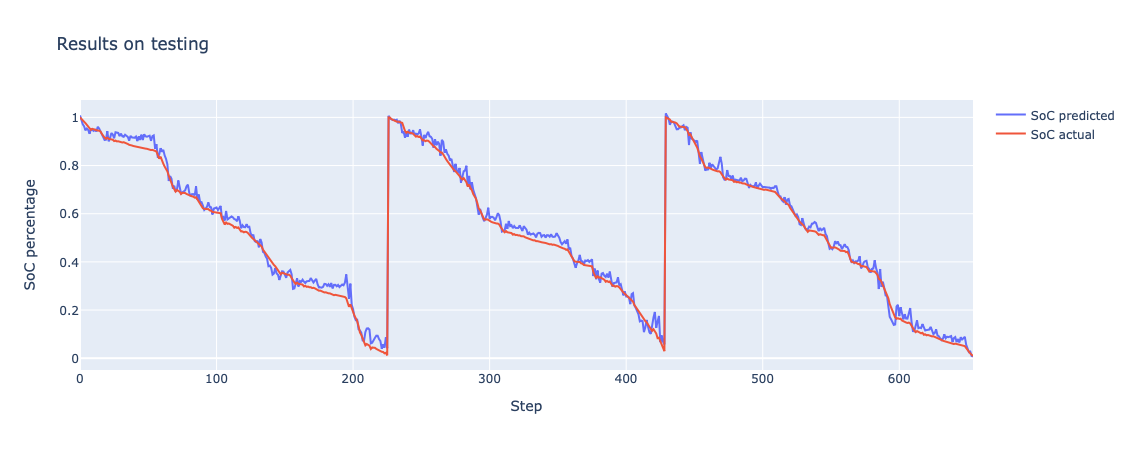

In [15]:
test_x, test_y = get_test_data(['10degC/571_Mixed4',
                                '10degC/571_Mixed5',
                                '10degC/571_Mixed6'])

print(model.evaluate(test_x, test_y))
plot_test_performance(test_x, test_y)

## 25C

In [16]:
test_x, test_y = get_test_data(['25degC/552_Mixed4', 
                                '25degC/552_Mixed5', 
                                '25degC/552_Mixed6'])

print(model.evaluate(test_x, test_y))
plot_test_performance(test_x, test_y)

2020/12/27 10:22:29 [INFO]: There is a NaN in cycle 10degC/582_LA92, removing row
2020/12/27 10:24:21 [INFO]: Train x: (9929, 300, 3), train y: (9929, 300, 1) | Test x: (709, 300, 3), test y: (709, 300, 1)


23/23 [==============================] - 2s 89ms/step - loss: 2.4968e-04 - mean_squared_error: 4.9936e-04 - mean_absolute_error: 0.0154 - mean_absolute_percentage_error: 6.2340 - rmse: 0.0223
[0.0002496797824278474, 0.0004993595648556948, 0.015443895012140274, 6.234015464782715, 0.02234635502099991]


## 40C

2020/12/27 10:24:27 [INFO]: There is a NaN in cycle 10degC/582_LA92, removing row
2020/12/27 10:26:22 [INFO]: Train x: (9929, 300, 3), train y: (9929, 300, 1) | Test x: (59, 300, 3), test y: (59, 300, 1)


2/2 [==============================] - 0s 50ms/step - loss: 0.0982 - mean_squared_error: 0.1963 - mean_absolute_error: 0.3658 - mean_absolute_percentage_error: 176.6047 - rmse: 0.4431
[0.09816625714302063, 0.19633251428604126, 0.3657558262348175, 176.60470581054688, 0.44309425354003906]


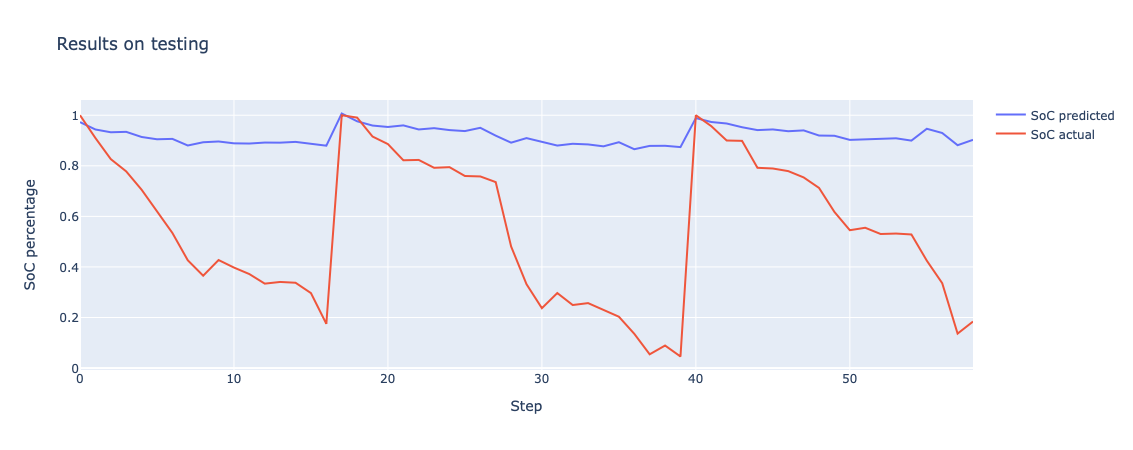

In [17]:
test_x, test_y = get_test_data(['40degC/562_Mixed4',
                                '40degC/562_Mixed5',
                                '40degC/562_Mixed6'])

print(model.evaluate(test_x, test_y))
plot_test_performance(test_x, test_y)

## -10C

In [18]:
test_x, test_y = get_test_data(['n10degC/602_Mixed4',
                                'n10degC/602_Mixed5',
                                'n10degC/604_Mixed6'])

print(model.evaluate(test_x, test_y))
plot_test_performance(test_x, test_y)

2020/12/27 10:26:24 [INFO]: There is a NaN in cycle 10degC/582_LA92, removing row
2020/12/27 10:28:13 [INFO]: Train x: (9929, 300, 3), train y: (9929, 300, 1) | Test x: (544, 300, 3), test y: (544, 300, 1)


17/17 [==============================] - 1s 82ms/step - loss: 9.5917e-04 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0345 - mean_absolute_percentage_error: 14.7907 - rmse: 0.0438
[0.0009591669077053666, 0.0019183338154107332, 0.034453731030225754, 14.790718078613281, 0.043798789381980896]


## -20C

2020/12/27 10:28:18 [INFO]: There is a NaN in cycle 10degC/582_LA92, removing row
2020/12/27 10:30:07 [INFO]: Train x: (9929, 300, 3), train y: (9929, 300, 1) | Test x: (391, 300, 3), test y: (391, 300, 1)


13/13 [==============================] - 1s 89ms/step - loss: 0.0102 - mean_squared_error: 0.0205 - mean_absolute_error: 0.1053 - mean_absolute_percentage_error: 49.8931 - rmse: 0.1431
[0.010241638869047165, 0.02048327773809433, 0.10531064867973328, 49.89305877685547, 0.14311979711055756]


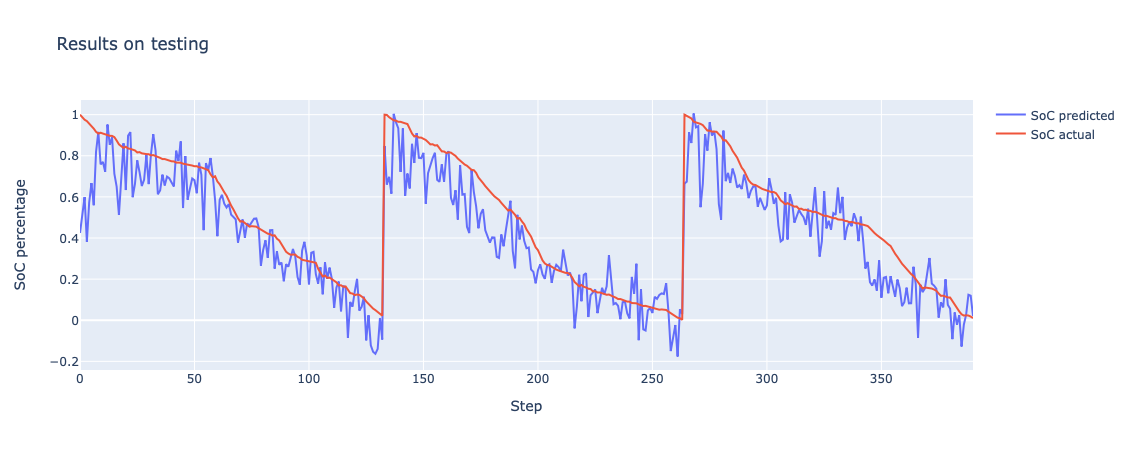

In [19]:
test_x, test_y = get_test_data(['n20degC/611_Mixed4',
                                'n20degC/611_Mixed5',
                                'n20degC/611_Mixed6'])

print(model.evaluate(test_x, test_y))
plot_test_performance(test_x, test_y)